In [1]:
# Essentials
import time
import copy
from collections import OrderedDict
import random
import os
from tifffile import TiffFile
from PIL import Image, ImageOps
from pathlib import Path
from tqdm.notebook import tqdm
# Data
import numpy as np
import pandas as pd
# Plot
import matplotlib.pyplot as plt
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
# Torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
# segmentation_models_pytorch
import segmentation_models_pytorch as smp
# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Local 
from unet import UNet
from LCD import LandCoverData
from dataset import *
from train import *
from utils import *
from metrics import *
from losses import *
LCD = LandCoverData()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


# ⚠️Seed everything!
It's important to seed everything for reproducibility.

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
seed = 2021
seed_everything(seed)

# 📜 Set all variables here
In this cell, we define all hyperparameters that we will be using for the rest of the notebook. It helps to group them in one place so we can track them better.

In [4]:
MODEL = 'resnet34'
SEGMENT = 'UNET'
OPTIMIZER = 'adam'
NB_EPOCHS = 40
LEARNING_RATE = 0.001
BATCH_SIZE = 12
IN_CHANNELS = 4

filename = f"{SEGMENT}_{MODEL}_{NB_EPOCHS}_epochs_{LEARNING_RATE}_learningrate_{BATCH_SIZE}_batchsize_seed_{seed}_CHANNELS_{IN_CHANNELS}"
print(filename)

UNET_resnet34_40_epochs_0.001_learningrate_12_batchsize_seed_2021_CHANNELS_4


### Define custom transforms

In [5]:
train_transform = A.Compose([
    A.ToFloat(max_value=65535.0),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=5, p=0.5),
    A.Blur(p=0.25),
    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.FromFloat(max_value=65535.0),
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(1, 1, 1, 1), max_pixel_value=65535),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(1, 1, 1, 1), max_pixel_value=65535),
    ToTensorV2()
])

### Initiate datasets
Here we perform a train/validation split in otder to evaluate our model. We then feed them to the ImageSegementationDataset so to make the datasets.

In [35]:
train_dir='Small_dataset/train'
test_dir = 'Small_dataset/test'
train_idx, val_idx = train_val_dataset(train_dir, val_split=0.2)
train_set = ImageSegementationDataset(train_dir, in_channels=IN_CHANNELS, path_index=train_idx, mode='train', transforms=train_transform)
val_set = ImageSegementationDataset(train_dir, in_channels=IN_CHANNELS, path_index=val_idx, mode='valid', transforms=test_transform)
test_set = ImageSegementationDataset(test_dir, in_channels=IN_CHANNELS, mode='test', transforms=test_transform)

print("Train set contains", len(train_set), "elements")
print("Validation set contains", len(val_set), "elements")
print("Test set contains", len(test_set), "elements")

Train set contains 16 elements
Validation set contains 4 elements
Test set contains 20 elements


In [36]:
loader_train = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

data_sizes = {"train": len(loader_train), "valid": len(loader_valid)}
print("There are", data_sizes['train'], "batches in the training set")
print("There are", data_sizes['valid'], "batches in the validation set")

There are 2 batches in the training set
There are 1 batches in the validation set


In [46]:
def weight_train_dataset(train_set):
    class_distribution = np.zeros((1, LCD.N_CLASSES))
    for image, mask in iter(train_set):
        class_distribution += np.apply_along_axis(np.bincount, axis=1, arr=mask.flatten(1), minlength=LCD.N_CLASSES)
    return class_distribution

def get_weights(train_set):
    class_dist = weight_train_dataset(train_set)
    weights = np.zeros((1, LCD.N_CLASSES))
    weights[:,len(LCD.IGNORED_CLASSES_IDX):] = (1 / class_dist[:,2:])* class_dist[:,2:].sum() / (LCD.N_CLASSES-2)
    return torch.FloatTensor(weights)

weights = get_weights(train_set)
weights = weights.to(device)

# Training the Model

We start by initializing our model along with the loss and optimizers and feed that to the Trainer class.

In [33]:
def prepare(model, segment, optimizer, nb_epochs, learning_rate, batch_size, in_channels, weights=None):
    if segment == 'UNET':
        model = smp.Unet(encoder_name=MODEL,in_channels=IN_CHANNELS, classes=10, activation=None)
    elif segment == 'LINKNET':
        model = smp.LinkNet(encoder_name=MODEL,in_channels=IN_CHANNELS, classes=10, activation=None)
    if optimizer == 'adam':
        optimizer_ft = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif optimizer == 'sgd':
        optimizer_ft = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)
    criterion = CombinedLoss(weights=weights)
    loaders = {
        "train": loader_train,
        "val": loader_valid
    }
    return model, loaders, optimizer_ft, criterion, scheduler

In [34]:
model, loaders, optimizer_ft, criterion, scheduler = prepare(
    model = MODEL, 
    segment = SEGMENT, 
    optimizer = OPTIMIZER, 
    nb_epochs = NB_EPOCHS, 
    learning_rate = LEARNING_RATE, 
    batch_size = BATCH_SIZE, 
    in_channels = IN_CHANNELS
    weights=None)
trainer = Trainer(model, loaders, optimizer_ft, criterion, scheduler, device)
trainer.reset()

Now we run the training

In [16]:
trainer.run(NB_EPOCHS, reduce_on_plateau=True)

  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 41/40 Learning rate: 6.25e-05
Epoch 41/40 Training Loss: 0.31081608852669174 Training BCE Loss 0.08762600639682423 Training Dice Loss 0.2231900826072364 Training IoU: 0.5886431170995502 Training KL: 0.03343319837137135
Epoch 41/40 Validation Loss: 0.32049321805196285 Validation BCE Loss 0.09059498777377953 Validation Dice Loss 0.22989822969949747 Validation IoU: 0.5850923033286785 Validation KL: 0.05162021510515601


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 42/40 Learning rate: 6.25e-05
Epoch 42/40 Training Loss: 0.3116133177633316 Training BCE Loss 0.08762083415905828 Training Dice Loss 0.223992483882235 Training IoU: 0.5879150993864062 Training KL: 0.03355344997083351
Epoch 42/40 Validation Loss: 0.31127262399999067 Validation BCE Loss 0.08627094542999483 Validation Dice Loss 0.22500167835298865 Validation IoU: 0.5896885465685143 Validation KL: 0.0425334384442494


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 43/40 Learning rate: 3.125e-05
Epoch 43/40 Training Loss: 0.3102205821221569 Training BCE Loss 0.08778660300294268 Training Dice Loss 0.22243397942134643 Training IoU: 0.5893522348203313 Training KL: 0.03323369690561181
Epoch 43/40 Validation Loss: 0.312135491893901 Validation BCE Loss 0.08803455189207997 Validation Dice Loss 0.2241009405322831 Validation IoU: 0.5914269450390096 Validation KL: 0.04302608334769208


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 44/40 Learning rate: 3.125e-05
Epoch 44/40 Training Loss: 0.31094164998910334 Training BCE Loss 0.08741912532776039 Training Dice Loss 0.22352252492721933 Training IoU: 0.5885859744281035 Training KL: 0.03277331215401039
Epoch 44/40 Validation Loss: 0.31065740453193874 Validation BCE Loss 0.08714876601225349 Validation Dice Loss 0.22350863900192347 Validation IoU: 0.5921010315050835 Validation KL: 0.04175568670894499


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 45/40 Learning rate: 3.125e-05
Epoch 45/40 Training Loss: 0.3094023331721817 Training BCE Loss 0.08727290771980162 Training Dice Loss 0.22212942548863596 Training IoU: 0.5902615461392036 Training KL: 0.03287877262941143
Epoch 45/40 Validation Loss: 0.3072411790249031 Validation BCE Loss 0.08408170211517695 Validation Dice Loss 0.22315947569207467 Validation IoU: 0.5945127433811722 Validation KL: 0.036238396121570406


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 46/40 Learning rate: 3.125e-05
Epoch 46/40 Training Loss: 0.30889493891695896 Training BCE Loss 0.08750923649262145 Training Dice Loss 0.2213857023699537 Training IoU: 0.5908507104188485 Training KL: 0.03266935263654265
Epoch 46/40 Validation Loss: 0.3134234106367074 Validation BCE Loss 0.08815681523248602 Validation Dice Loss 0.22526659500637486 Validation IoU: 0.5891820805857265 Validation KL: 0.044947224048033904


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 47/40 Learning rate: 3.125e-05
Epoch 47/40 Training Loss: 0.3097158722754716 Training BCE Loss 0.0873751091103871 Training Dice Loss 0.22234076320134036 Training IoU: 0.5897133252865009 Training KL: 0.03314973219613176
Epoch 47/40 Validation Loss: 0.3128890240366019 Validation BCE Loss 0.08743135550309539 Validation Dice Loss 0.22545766847322674 Validation IoU: 0.59058808760784 Validation KL: 0.043272710536871865


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 48/40 Learning rate: 3.125e-05
Epoch 48/40 Training Loss: 0.30768544782203866 Training BCE Loss 0.08735067911585076 Training Dice Loss 0.2203347688149555 Training IoU: 0.5920778697333723 Training KL: 0.03288151522813998
Epoch 48/40 Validation Loss: 0.3053430906198557 Validation BCE Loss 0.08437153513763329 Validation Dice Loss 0.22097155557867007 Validation IoU: 0.5963946216364524 Validation KL: 0.035973128518748884


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 49/40 Learning rate: 3.125e-05
Epoch 49/40 Training Loss: 0.3091970175770561 Training BCE Loss 0.08730692681097346 Training Dice Loss 0.2218900910077884 Training IoU: 0.590331308709295 Training KL: 0.03327030576700152
Epoch 49/40 Validation Loss: 0.3119866453038836 Validation BCE Loss 0.08692619513153645 Validation Dice Loss 0.22506045065458538 Validation IoU: 0.590616725785055 Validation KL: 0.040755534376116766


  0%|          | 0/1233 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 50/40 Learning rate: 3.125e-05
Epoch 50/40 Training Loss: 0.3087013218814729 Training BCE Loss 0.08722359700383737 Training Dice Loss 0.22147772488367817 Training IoU: 0.5908254303607381 Training KL: 0.03250612587386551
Epoch 50/40 Validation Loss: 0.3116539012170532 Validation BCE Loss 0.08618261973738285 Validation Dice Loss 0.22547128099743216 Validation IoU: 0.5907798195160027 Validation KL: 0.03927509122971775


  0%|          | 0/1233 [00:00<?, ?it/s]

KeyboardInterrupt: 

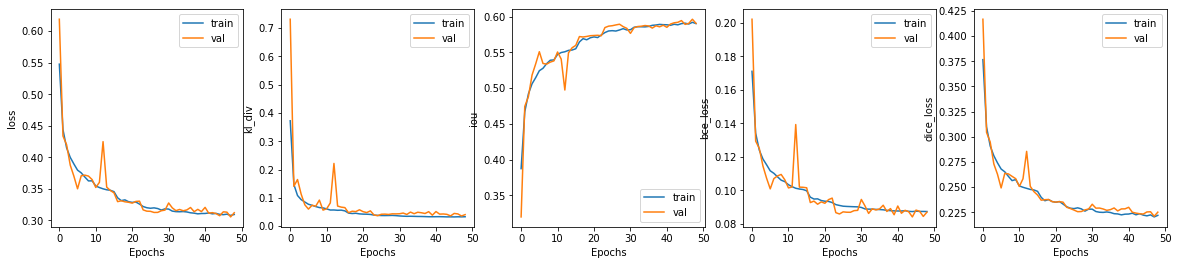

In [17]:
trainer.plot(figsize=(20,4))

# Saving logger to csv
We save all logs into a csv for a later use.

In [22]:
logs_dir = {'train':'logs/train', 'val': 'logs/val'}
for mode_ in ['train', 'val']:
    dict_df = {}
    for key in trainer.logger:
        dict_df[key] = trainer.logger[key][mode_]
    df_ = pd.DataFrame.from_dict(dict_df)
    df_.to_csv(os.path.join(logs_dir[mode_], f'{filename}_{mode_}.csv'))

# Submission time

In [18]:
trainer.generate_submission(loader_test, filename)

  0%|          | 0/421 [00:00<?, ?it/s]

File is saved as UNET_resnet18_40_epochs_0.001_learningrate_12_batchsize_seed_2021_CHANNELS_4.csv


# Saving the best model

In [15]:
best_params = trainer.get_best_model()
torch.save(best_params,f"{filename}.pt")

Model has a best KL divergence of 0.03705570041401105
